In [3]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# loading forage quality data
import math
import re
import numpy as np
import pandas as pd

tmean = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/tmean_prism_pennsylvania_data_1990_2023.csv')
ppt = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/ppt_prism_pennsylvania_data_1990_2023.csv')
forage = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/foraging_quality_pennsylvania_data.csv')

cols = forage.columns.tolist()

# create new columns 
new_cols = []
for col in cols:
    if "Forage" in col:
        code = col.split("_")[1]
        number = re.findall(r'\d+', code)[0]
        new_cols.append(number)
    else:
        new_cols.append(col)

new_cols

# rename columns
forage = forage.rename(columns=dict(zip(forage.columns, new_cols)))

# create grid_id column
forage["grid_id"] = forage["col"].astype(str) + "_" + forage["row"].astype(str)

possible_cols = forage.col.tolist()
possible_rows = forage.row.tolist()

def get_adjacent_cols_rows(col, row, possible_cols=possible_cols, possible_rows=possible_rows):
    adjacent_cols_rows = []
    
    for c, r in zip(possible_cols, possible_rows):
        if abs(c - col) <= 1 and abs(r - row) <= 1 and (c != col or r != row):
            adjacent_cols_rows.append((c, r))
    
    return adjacent_cols_rows



def getGridQuality(col, row, year, forage=forage):
    grid_id = str(col) + "_" + str(row)
    grid_quality = forage[forage["grid_id"] == grid_id][str(year)].values[0]
    return grid_quality


def getGridForageQuality(col, row, year):
    '''
    Get forage quality for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year
    
    output:
    float [0,233]
    '''
    grid_quality = getGridQuality(col, row, year)
    if math.isnan(grid_quality):
        adjacent_cols_rows = get_adjacent_cols_rows(col, row)
        adjacent_quality = []
        for c, r in adjacent_cols_rows:
            grid_quality = getGridQuality(c, r, year)
            if not math.isnan(grid_quality):
                adjacent_quality.append(grid_quality)
        return np.mean(adjacent_quality)
    else:
        return grid_quality




################# tmean data #################

cols = tmean.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_tmean" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)
new_cols

tmean = tmean.rename(columns=dict(zip(tmean.columns, new_cols)))


tmean["grid_id"] = tmean["col"].astype(str) + "_" + tmean["row"].astype(str)

def getTmean(col, row, day, month, year, tmean=tmean):
    '''
    Get temperature data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    tmean: pd.DataFrame, temperature data

    output:
    float, temperature in degrees celcius
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    tmean = tmean[tmean["grid_id"] == grid_id][date].values[0]
    return tmean

############### ppt data #################

cols = ppt.columns.tolist()

new_cols = []
for col in cols:
    if "PRISM_ppt" in col:
        new_cols.append(col.split("_")[-2])
    else:
        new_cols.append(col)

ppt = ppt.rename(columns=dict(zip(ppt.columns, new_cols)))

ppt["grid_id"] = ppt["col"].astype(str) + "_" + ppt["row"].astype(str)

def getPpt(col, row, day, month, year, ppt=ppt):
    '''
    Get precipitation data for a given grid cell
    col: int, column number
    row: int, row number
    day: int, day of the month
    month: int, month of the year
    year: int, year
    ppt: pd.DataFrame, precipitation data

    output:
    float, precipitation in mm
    '''
    if month < 10:
        month = "0" + str(month)
    if day < 10:
        day = "0" + str(day)
    date = str(year) + "" + str(month) + "" + str(day)
    grid_id = str(col) + "_" + str(row)
    ppt = ppt[ppt["grid_id"] == grid_id][date].values[0]
    return ppt

In [3]:
################ Modeling ################

In [5]:
grids = forage[["col", "row", "grid_id"]]

In [6]:
# Emergence Model
import datetime
from datetime import datetime, timedelta
def getEmergence(col, row, year, sex="female"):
    '''
    Get emergence date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year

    output:
    datetime.date, emergence date
    '''
    # function constants
    #female_thermal_temp = 179.8  #white et al
    female_thermal_temp = 209 # adam et al
    male_thermal_temp = 125.2
    #female_dev_temp = 8.6 # white et al
    female_dev_temp = 6.53 # adam et al
    male_dev_temp = 8.9


    starting_date = f"{year-1}-11-01" # september 1st of the previous year
    starting_date = datetime.strptime(starting_date, "%Y-%m-%d").date()
    cumulative_degrees = 0.0
    new_date = starting_date

    if sex == "female":
        thermal_temp = female_thermal_temp
    elif sex == "male":
        thermal_temp = male_thermal_temp

    if sex == "female":
        dev_temp = female_dev_temp
    elif sex == "male":
        dev_temp = male_dev_temp

    # determine emergence date
    cumulative_degrees = 0.0
    development_days = 0
    while cumulative_degrees < thermal_temp:
        daily_tmean = getTmean(col, row, new_date.day, new_date.month, new_date.year)
        if daily_tmean >= dev_temp:
            cumulative_degrees += float(daily_tmean - dev_temp)
            development_days += 1

        new_date += timedelta(days=1)

    return new_date
    '''
    return {

        "emergence_date": new_date,
        "development_days": development_days
    }
    '''


In [22]:
# Reproduction Model

precipitation_threshold = 1

def getSpatiallyExplicitReproduction(col, row, emergence, longevity=22, temperature_threshold=13.9, mating_days=2, precipitation_threshold=5, forage_threshold_percentile=10):
    '''
    Get reproduction date for a given grid cell
    col: int, column number
    row: int, row number
    year: int, year
    emergence: datetime.date, emergence date

    output:
    datetime.date, reproduction date
    '''

    # function constants
    eggs = 0
    egg_delta = 1 # change in eggs per day
     # update starting date
    starting_date = emergence + timedelta(days=mating_days)

    non_foraging_days = 0
    precipitation_effect = 0
    temperature_effect = 0
    temps = []
    ppts = []
    
    for i in range(longevity-mating_days):
        # get daily temperature and precipitation
        daily_tmean = getTmean(col, row, starting_date.day, starting_date.month, starting_date.year)
        daily_ppt = getPpt(col, row, starting_date.day, starting_date.month, starting_date.year)

        temps.append(daily_tmean)
        ppts.append(daily_ppt)

        # update eggs
        if daily_tmean >= temperature_threshold and daily_ppt < precipitation_threshold:
            eggs += egg_delta
            
        else:
            non_foraging_days += 1
            if daily_tmean < temperature_threshold:
                temperature_effect += 1
            if daily_ppt >= precipitation_threshold:
                precipitation_effect += 1


        #print(f"Date {starting_date},\nTmean {daily_tmean},\nPPT {daily_ppt},\nEggs {eggs}")

        # update date
        starting_date += timedelta(days=1)
        

    return {
        "eggs": eggs,
        "non_foraging_days": non_foraging_days,
        "precipitation_effect": precipitation_effect,
        "temperature_effect": temperature_effect,
        "temps": temps,
        "ppts": ppts
    }

        

In [15]:
# Egg and Larva Mortality Model

def getEggLarvaMortality(col, row, emergence, mating_days=2):

    # constants
    ldt = 10 # c
    udt = 30 # c

    total_dev_days = 38 # days 20 forages + 4 egg + 14 larva

    startdate = emergence + timedelta(days=mating_days)

    mortality_days = 0

    for i in range(total_dev_days):

        daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)

        if daily_tmean < ldt or daily_tmean > udt:
            mortality_days += 1

        startdate += timedelta(days=1)

    return mortality_days/total_dev_days



In [16]:
# Pre-wintering Mortality Model

def getPreWinteringMortality(col, row, year):

    startdate = datetime(year, 9, 1)
    enddate = datetime(year, 11, 1)

    dev_temp = 6.53

    dev_days = 0

    while startdate < enddate:
        daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
        if daily_tmean > dev_temp:
            dev_days += 1

        startdate += timedelta(days=1)

    return dev_days/61
    

In [17]:
# Wintering Mortality Model

def getWinteringTemperature(col, row, year):
    
        startdate = datetime(year, 11, 1)
        enddate = datetime(year+1, 2, 1)
    
        temps = []
    
        while startdate < enddate:
            daily_tmean = getTmean(col, row, startdate.day, startdate.month, startdate.year)
            temps.append(daily_tmean)
    
            startdate += timedelta(days=1)
    
        return np.mean(temps)

In [3]:
import pandas as pd

In [4]:
pa_point = pd.read_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/output/pennsylvania_prism_grid_points.csv')

ParserError: Error tokenizing data. C error: Expected 13 fields in line 3, saw 17


In [18]:
######################## Run Simulation ################

In [19]:
#years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
#years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
#years = [1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
years = [2020, 2021, 2022]

In [20]:
len(years)

3

In [13]:
col = 1131
row = 219
df = pd.DataFrame(years, columns=["year"])
df['emergence'] = df['year'].apply(lambda x: getEmergence(col, row, x))

In [41]:
def getJulianDay(emergence):
    emergence = datetime.strptime(emergence, '%Y-%m-%d').date()
    starting_date = datetime.strptime(f'{emergence.year}-01-01', '%Y-%m-%d').date()
    return (emergence - starting_date).days + 1

df['julian_day'] = df['emergence'].apply(lambda x: getJulianDay(str(x)))

<Axes: xlabel='year', ylabel='julian_day'>

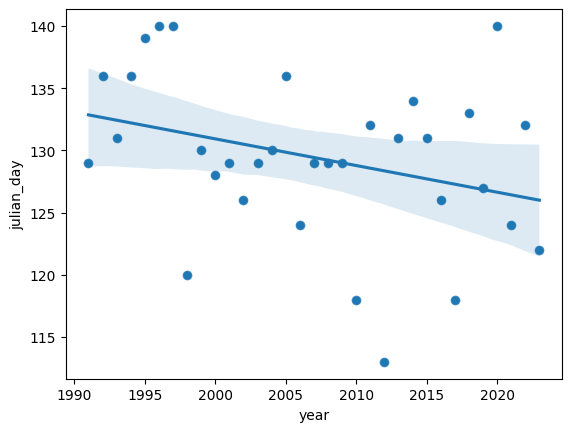

In [42]:
import seaborn as sns
# FILEPATH: /Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/research/modeling.ipynb
df.plot(x='year', y='julian_day', kind='scatter')
sns.regplot(x='year', y='julian_day', data=df)
#df.scatter(x='year', y='julian_day', kind='line')

In [23]:

for year in years:
    #grids[f"emergence_{year}"] = grids.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)
    grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
    grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortality(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
    grids[f"pre_wintering_mortality_{year}"] = grids.apply(lambda x: getPreWinteringMortality(x["col"], x["row"], year), axis=1)
    grids[f"wintering_temperature_{year}"] = grids.apply(lambda x: getWinteringTemperature(x["col"], x["row"], year), axis=1)

/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_98165/872329460.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"reproduction_{year}"] = grids.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
/var/folders/r5/48dgr3g12qg3cwmg9f6v0cwc0000gn/T/ipykernel_98165/872329460.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grids[f"egg_larva_mortality_{year}"] = grids.apply(lambda x: getEggLarvaMortality(x["col"], x["row"], x[f"emergence_{y

KeyError: 'emergence_2021'

In [45]:
#grids.to_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/output/emergence_reproduction_13_9C_5mm_adam_November_1991_2023.csv', index=False)
grids.to_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/output/emergence_reproduction_13_9C_5mm_adam_November_2020_2022.csv', index=False)

In [12]:
######### spatially explicit simulation #########

In [13]:
### spatially explicit model

'''
grids_sp = forage[["col", "row", "grid_id"]]

for year in years:
    grids_sp[f"emergence_{year}"] = grids_sp.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)
    grids_sp[f"reproduction_{year}"] = grids_sp.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)
'''

'\ngrids_sp = forage[["col", "row", "grid_id"]]\n\nfor year in years:\n    grids_sp[f"emergence_{year}"] = grids_sp.apply(lambda x: getEmergence(x["col"], x["row"], year), axis=1)\n    grids_sp[f"reproduction_{year}"] = grids_sp.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence_{year}"]), axis=1)\n'

In [14]:
#grids_sp.to_csv('/Users/edwardamoah/Documents/GitHub/OsmiaPopModel/osmiaPopModel_python/output/spatially_explicit_reproduction_with_max_eggs_with_foraging_quality_5mm_precip_threshold_with_temp_and_forage_scores.csv', index=False)

In [15]:
############ Study Sites ################

In [16]:
'''
sites = ['GreenHouse', "Natalie", 'Mendel', 'Lemont']
lat = [40.802, 40.799, 40.884, 40.808]
lon = [-77.862, -77.905, -77.834, -77.82]

df_sites = pd.DataFrame({
    "site": sites,
    "lat": lat,
    "lon": lon
})


df_st = pd.DataFrame({
    "col": [1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131],
    "row": [219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219],
    "year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
})

df_st["emergence"] = df_st.apply(lambda x: getEmergence(x["col"], x["row"], x["year"]), axis=1)


#df_st["emergence_date"] = pd.to_datetime(df_st["emergence_date"])
#for year in years:
df_st["reproduction"] = df_st.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence"]), axis=1)


df_st["non_foraging_days"] = [x['non_foraging_days'] for x in df_st["reproduction"].tolist()]
df_st["eggs"] = [x['eggs'] for x in df_st["reproduction"].tolist()]
df_st["precipitation_effect"] = [x['precipitation_effect'] for x in df_st["reproduction"].tolist()]
df_st["temperature_effect"] = [x['temperature_effect'] for x in df_st["reproduction"].tolist()]


def getJulianDay(emergence):
    emergence = datetime.strptime(emergence, '%Y-%m-%d').date()
    starting_date = datetime.strptime(f'{emergence.year}-01-01', '%Y-%m-%d').date()
    return (emergence - starting_date).days + 1


df_st["Julian_day"] = df_st["emergence"].apply(lambda x: getJulianDay(str(x)))
'''

'\nsites = [\'GreenHouse\', "Natalie", \'Mendel\', \'Lemont\']\nlat = [40.802, 40.799, 40.884, 40.808]\nlon = [-77.862, -77.905, -77.834, -77.82]\n\ndf_sites = pd.DataFrame({\n    "site": sites,\n    "lat": lat,\n    "lon": lon\n})\n\n\ndf_st = pd.DataFrame({\n    "col": [1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131, 1131],\n    "row": [219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219, 219],\n    "year": [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]\n})\n\ndf_st["emergence"] = df_st.apply(lambda x: getEmergence(x["col"], x["row"], x["year"]), axis=1)\n\n\n#df_st["emergence_date"] = pd.to_datetime(df_st["emergence_date"])\n#for year in years:\ndf_st["reproduction"] = df_st.apply(lambda x: getSpatiallyExplicitReproduction(x["col"], x["row"], x[f"emergence"]), axis=1)\n\n\ndf_st["non_foraging_days"] = [x[\'non_foraging_days\'] for x in df_st["reproduction"].tolist()]\ndf

In [17]:
'''
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample DataFrame (replace this with your actual DataFrame)
data = {
    'x': [1, 2, 3, 4, 5],
    'y': [2, 3, 5, 4, 6]
}
df = df_st #pd.DataFrame(data)

columns = ['year', 'non_foraging_days', 'eggs', 'precipitation_effect', 'temperature_effect']
# Scatter plot
i=4
plt.scatter(df['year'], df[columns[i]], label='Number of Cold Days')

# Linear regression
coefficients = np.polyfit(df['year'], df[columns[i]], 1)
slope = coefficients[0]
intercept = coefficients[1]
trendline = f'Regression line: y={slope:.2f}x{intercept:.2f}'
plt.plot(df['year'], intercept + slope * df['year'], color='red', label=trendline)

# Add labels and legend
plt.xlabel('Year')
plt.ylabel('Days')
plt.title('Number of Cold (<13.9 C) Days vs Year')
plt.legend()

# Show plot
plt.show()
'''

"\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Sample DataFrame (replace this with your actual DataFrame)\ndata = {\n    'x': [1, 2, 3, 4, 5],\n    'y': [2, 3, 5, 4, 6]\n}\ndf = df_st #pd.DataFrame(data)\n\ncolumns = ['year', 'non_foraging_days', 'eggs', 'precipitation_effect', 'temperature_effect']\n# Scatter plot\ni=4\nplt.scatter(df['year'], df[columns[i]], label='Number of Cold Days')\n\n# Linear regression\ncoefficients = np.polyfit(df['year'], df[columns[i]], 1)\nslope = coefficients[0]\nintercept = coefficients[1]\ntrendline = f'Regression line: y={slope:.2f}x{intercept:.2f}'\nplt.plot(df['year'], intercept + slope * df['year'], color='red', label=trendline)\n\n# Add labels and legend\nplt.xlabel('Year')\nplt.ylabel('Days')\nplt.title('Number of Cold (<13.9 C) Days vs Year')\nplt.legend()\n\n# Show plot\nplt.show()\n"

In [18]:
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_st.plot(x='Julian_day', y='temperature_effect', kind='scatter', label='Emergence date')

# Linear regression
coefficients = np.polyfit(df_st['Julian_day'], df_st['temperature_effect'], 1)
slope = coefficients[0]
intercept = coefficients[1]
trendline = f'Regression line: y={slope:.2f}x+{intercept:.2f}'
plt.plot(df_st['Julian_day'], intercept + slope * df_st['Julian_day'], color='red', label=trendline)

# Add labels and legend
plt.xlabel('Julian Date of Emergence')
plt.ylabel('Number of Cold Days')
plt.title('Number of Cold (<13.9 C) Days vs Julian Date of Emergence')
plt.legend()

# Show plot
plt.show()
'''


"\nimport pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndf_st.plot(x='Julian_day', y='temperature_effect', kind='scatter', label='Emergence date')\n\n# Linear regression\ncoefficients = np.polyfit(df_st['Julian_day'], df_st['temperature_effect'], 1)\nslope = coefficients[0]\nintercept = coefficients[1]\ntrendline = f'Regression line: y={slope:.2f}x+{intercept:.2f}'\nplt.plot(df_st['Julian_day'], intercept + slope * df_st['Julian_day'], color='red', label=trendline)\n\n# Add labels and legend\nplt.xlabel('Julian Date of Emergence')\nplt.ylabel('Number of Cold Days')\nplt.title('Number of Cold (<13.9 C) Days vs Julian Date of Emergence')\nplt.legend()\n\n# Show plot\nplt.show()\n"